In [1]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from mapie.regression import MapieRegressor
from sklearn.model_selection import KFold
from mapie.regression import MapieQuantileRegressor
from sklearn.ensemble import GradientBoostingRegressor

#utils data visualization
from utils.visualization import *
from utils.constants import *
from utils.plot_themes import *
from utils.model_utils import *

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import log_loss, brier_score_loss

import shap

#utils data visualization
from utils.visualization import *
from utils.constants import *
from utils.plot_themes import *
from utils.model_utils import *

# XAI methods
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence

c:\Users\VALER\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = load_and_info('data/df_investig_INR.csv')

columnas_a_eliminar = ['Unnamed: 0']

if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=columnas_a_eliminar)


,Column,Dtype,Missing,Unique,Sample values
0,Unnamed: 0,int64,0,133,"[0, 1, 2, 3, 4]"
1,INR,float64,0,75,"[4.3, 2.8, 2.12, 2.77, 2.36]"
2,CALCI,float64,0,53,"[7.52, 8.54, 2.21, 8.96, 9.12]"
3,HEMOGLOBINA,float64,0,93,"[10.3, 12.24, 8.7, 13.3, 14.0]"
4,VCM,float64,0,105,"[95.7, 103.26, 86.4, 80.6, 95.5]"
5,HEMATOCRIT,float64,0,108,"[31.8, 36.65, 43.2, 40.25, 41.93]"
6,PLAQUETES,float64,0,101,"[192.0, 177.36, 220.0, 200.0, 168.33]"
7,DIAGNOSTIC_ASSOCIAT,object,0,20,"[FA_NE, Flutter_NE, Valv_Aort_NReum_NE, EP_Oth..."
8,IMC,float64,0,106,"[27.33, 19.751666666666665, 27.425, 24.94, 34.13]"
9,HB_GLICOSILADA_A1C,float64,0,21,"[6.22, 8.0, 6.2, 6.3, 6.5]"



El juego de datos contiene 21 variables y 133 observaciones, de las cuales 0 son duplicadas.


### 2.2 División de los datos en conjuntos de datos de entrenamiento, validación y prueba

In [3]:
# Store in different lists the names of the categorical and numerical columns since they will be treated different 
categorical = df.select_dtypes(include=['object']).columns.tolist()  # for strings 
numerical = df.select_dtypes(include=['int64','float64']).columns.tolist() # for numbers
categorical

['DIAGNOSTIC_ASSOCIAT']

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Preparación de los datos de ejemplo (basado en tu descripción)
# Suponiendo que 'df' es tu DataFrame original
# Creamos variables dummies para la columna 'DIAGNÒSTIC_ASSOCIAT'
df_X_train_cat = pd.get_dummies(df['DIAGNOSTIC_ASSOCIAT'])
categorical_update = df_X_train_cat.columns.tolist()

df_filtrado = df[df['DIAGNOSTIC_ASSOCIAT'].isin(['FA_NE', 'EP_Other_No_CorPulm','FA_Cron', 'Flebitis_Profunda'])].copy()

In [5]:
# copy the original dataframe so further manipulations will not affect it 
df_select = df_filtrado.copy() 
categorical = df_select.select_dtypes(include=['object']).columns.tolist()
numerical = df_select.select_dtypes(include=['int64','float64']).columns.tolist()
numerical.remove('INR')

In [ ]:
# first separate the train from the test set
df_train_split, df_test_split = train_test_split(df_select, test_size=0.04, random_state=1)

# separate the train set into calibration set and proper training set
df_proper_train, df_cal = train_test_split(df_train_split, test_size=0.5, random_state=1)

len(df_train_split),len(df_cal), len(df_test_split)



(80, 48, 20)

In [31]:
df_train, df_test = train_test_split(df_select, test_size=0.20, random_state=1)
len(df_train),len(df_test)


(80, 20)

In [7]:
# reset index
df_train = df_train.reset_index(drop=True)
# define the target
y_train = df_train.INR.values
# remove the target from the features
del df_train['INR']

In [8]:
from sklearn.feature_extraction import DictVectorizer 

dv = DictVectorizer(sparse=False) # False bcs is not a sparse matrix (we do not have many zeros)

# TRAIN
train_dict = df_train[categorical].to_dict(orient='records') # records = to do it row-wise, not col-wise
X_train_cat = dv.fit_transform(train_dict) # make it a vector

df_X_train_cat = pd.DataFrame(X_train_cat,columns= dv.get_feature_names_out())

categorical_update = df_X_train_cat.columns.to_list()


In [9]:
# TRAIN
X_train_num = df_train[numerical].values

In [10]:
# TRAIN
X_train = np.column_stack([X_train_num, X_train_cat])
feature_names = numerical + categorical_update

df_X_train = pd.DataFrame(X_train, columns=feature_names)

In [11]:
# reset index
df_proper_train = df_proper_train.reset_index(drop=True)
# define the target
y_proper_train = df_proper_train.INR.values
# remove the target from the features
del df_proper_train['INR']

### 2.3 Codificación y normalización de las 'features'

In [12]:
from sklearn.feature_extraction import DictVectorizer 

dv = DictVectorizer(sparse=False) # False bcs is not a sparse matrix (we do not have many zeros)

# TRAIN
proper_train_dict = df_proper_train[categorical].to_dict(orient='records') # records = to do it row-wise, not col-wise
X_proper_train_cat = dv.fit_transform(proper_train_dict) # make it a vector

df_X_proper_train_cat = pd.DataFrame(X_proper_train_cat,columns= dv.get_feature_names_out())

# convert the dataframe to a np.array again
X_proper_train_cat = df_X_proper_train_cat.to_numpy()

categorical_update = df_X_proper_train_cat.columns.to_list()


In [13]:
# TRAIN
X_proper_train_num = df_proper_train[numerical].values
#X_train_num = scaler.fit_transform(X_train_num)

In [14]:
# TRAIN
X_proper_train = np.column_stack([X_proper_train_num, X_proper_train_cat])

In [15]:
feature_names = numerical + categorical_update
feature_names

#df_X_train = pd.DataFrame(X_train, columns=feature_names)

['CALCI',
 'HEMOGLOBINA',
 'VCM',
 'HEMATOCRIT',
 'PLAQUETES',
 'IMC',
 'HB_GLICOSILADA_A1C',
 'PES',
 'CRIBRATGE_ALIMENTACIO',
 'MAGNESI',
 'CLORUR',
 'CBPAAT',
 'VALORACIO_AUDIT_C',
 'NT_PROBNP',
 'CREATINA_KINASA_CK',
 'FREQ_CARDIACA',
 'PCR',
 'HEMATIES',
 'DIAGNOSTIC_ASSOCIAT=EP_Other_No_CorPulm',
 'DIAGNOSTIC_ASSOCIAT=FA_Cron',
 'DIAGNOSTIC_ASSOCIAT=FA_NE',
 'DIAGNOSTIC_ASSOCIAT=Flebitis_Profunda']

### 3. Aplicación del modelo de aprendizaje automático: Random forest

In [16]:

rf_model = RandomForestRegressor(
    n_estimators=500,
    min_samples_leaf=5,
    max_features=1.0,
    max_depth=None,      
    random_state=23,
    n_jobs=-1
)

model = rf_model.fit(X_proper_train, y_proper_train)

In [17]:
# preparation TEST data

# reset index after the splitting shuffling
df_test = df_test.reset_index(drop=True)
# define target of the test set
y_test = df_test.INR.values
   
# 1. encode the categorical features and remove redundant columns-------------    

test_dict = df_test[categorical].to_dict(orient='records')
X_test_cat = dv.transform(test_dict) 

# convert the data array to a dataframe
df_X_test_cat = pd.DataFrame(X_test_cat,columns= dv.get_feature_names_out())

# convert the dataframe to a np.array again
X_test_cat = df_X_test_cat.to_numpy()

# 2. scale the numerical features --------------------------------------------

X_test_num = df_test[numerical].values
#X_test_num = scaler.transform(X_test_num) 

# 3. join the matrices -------------------------------------------------------

X_test = np.column_stack([X_test_num, X_test_cat]) 

In [18]:
y_pred = rf_model.predict(X_test)

## Estrategia de entrenamiento: Split conforme prediction


### Método Split Conformal Prediction

In [19]:
# --- 2. EXTRACCIÓN DE DATOS NUMÉRICOS ---
# Extraemos los valores de las columnas numéricas para cada set
X_cal_num = df_cal[numerical].values
X_test_num = df_test[numerical].values
# --- 1. PREPARACIÓN DE CONJUNTOS DE CALIBRACIÓN Y TEST ---
# (Debemos repetir el proceso del DictVectorizer que hiciste para 'proper_train')

def preprocess_set(df, dict_vectorizer, categorical_cols, numerical_data_array):
    # Transformar categóricas usando el vectorizador ya ajustado (fit)
    dicts = df[categorical_cols].to_dict(orient='records')
    cat_features = dict_vectorizer.transform(dicts)
    # Combinar con las numéricas (asumiendo que X_..._num ya existen)
    return np.column_stack([numerical_data_array, cat_features])

# Asumo que ya tienes X_cal_num y X_test_num definidos como hiciste con el train
X_cal = preprocess_set(df_cal, dv, categorical, X_cal_num)
X_test = preprocess_set(df_test, dv, categorical, X_test_num)

# Definir los targets reales (y)
y_cal = df_cal.INR.values
y_test = df_test.INR.values

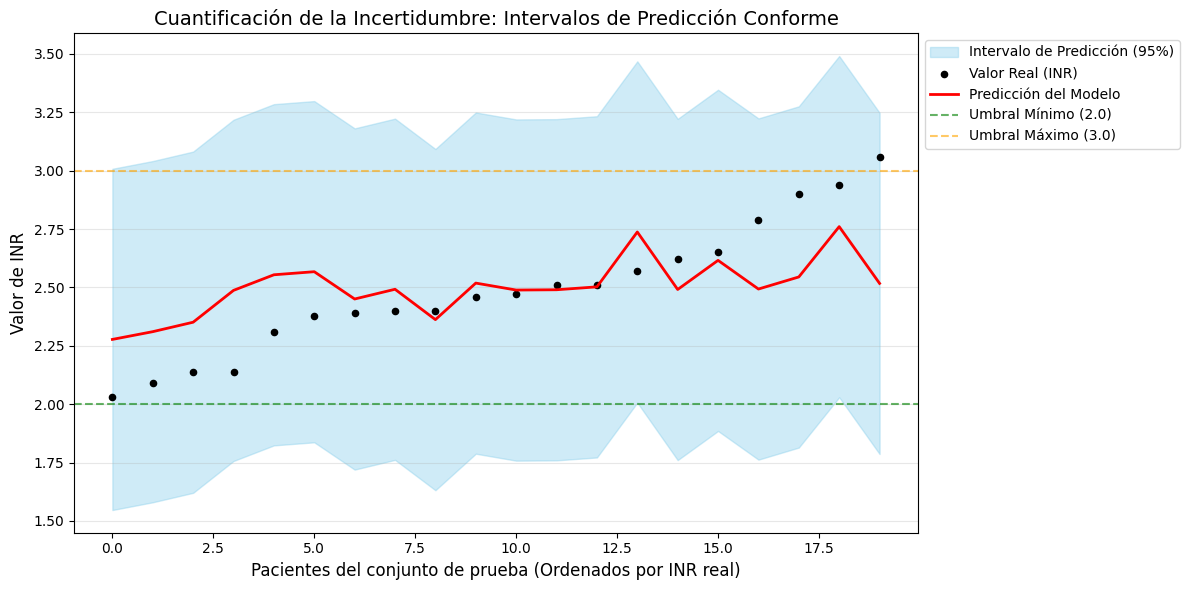

In [20]:
import matplotlib.pyplot as plt

mapie = MapieRegressor(estimator=model, cv="prefit", method="base")

# El paso de 'fit' en MAPIE con cv="prefit" NO entrena el bosque, 
# solo calcula los residuos en el set de CALIBRACIÓN para medir la incertidumbre.
mapie.fit(X_cal, y_cal)

alpha = 0.05
y_pred_point, y_pis = mapie.predict(X_test, alpha=alpha)

# Extraemos los límites para los cálculos
y_lower = y_pis[:, 0, 0]
y_upper = y_pis[:, 1, 0]
# 1. Preparar los datos para una visualización ordenada
# Creamos un DataFrame temporal para ordenar por el valor real (y_test)
plot_df = pd.DataFrame({
    'Real': y_test,
    'Predicho': y_pred_point,
    'Inferior': y_lower,
    'Superior': y_upper
}).sort_values(by='Real').reset_index(drop=True)

# 2. Crear la figura
plt.figure(figsize=(12, 6))

# Dibujar los intervalos (área sombreada)
plt.fill_between(plot_df.index, plot_df['Inferior'], plot_df['Superior'], 
                 color='skyblue', alpha=0.4, label='Intervalo de Predicción (95%)')

# Dibujar los valores reales y las predicciones
plt.scatter(plot_df.index, plot_df['Real'], color='black', s=20, label='Valor Real (INR)', zorder=3)
plt.plot(plot_df.index, plot_df['Predicho'], color='red', linewidth=2, label='Predicción del Modelo', zorder=4)

# 3. Añadir Umbrales Clínicos (2.0 y 3.0)
plt.axhline(y=2.0, color='green', linestyle='--', alpha=0.6, label='Umbral Mínimo (2.0)')
plt.axhline(y=3.0, color='orange', linestyle='--', alpha=0.6, label='Umbral Máximo (3.0)')

# 4. Estética del gráfico
plt.title('Cuantificación de la Incertidumbre: Intervalos de Predicción Conforme', fontsize=14)
plt.xlabel('Pacientes del conjunto de prueba (Ordenados por INR real)', fontsize=12)
plt.ylabel('Valor de INR', fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

plt.show()

### Cross-Validation Conformal Prediction (Jackknife+)

c:\Users\VALER\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\VALER\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\VALER\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\VALER\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
c:\Users\VALER\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\util

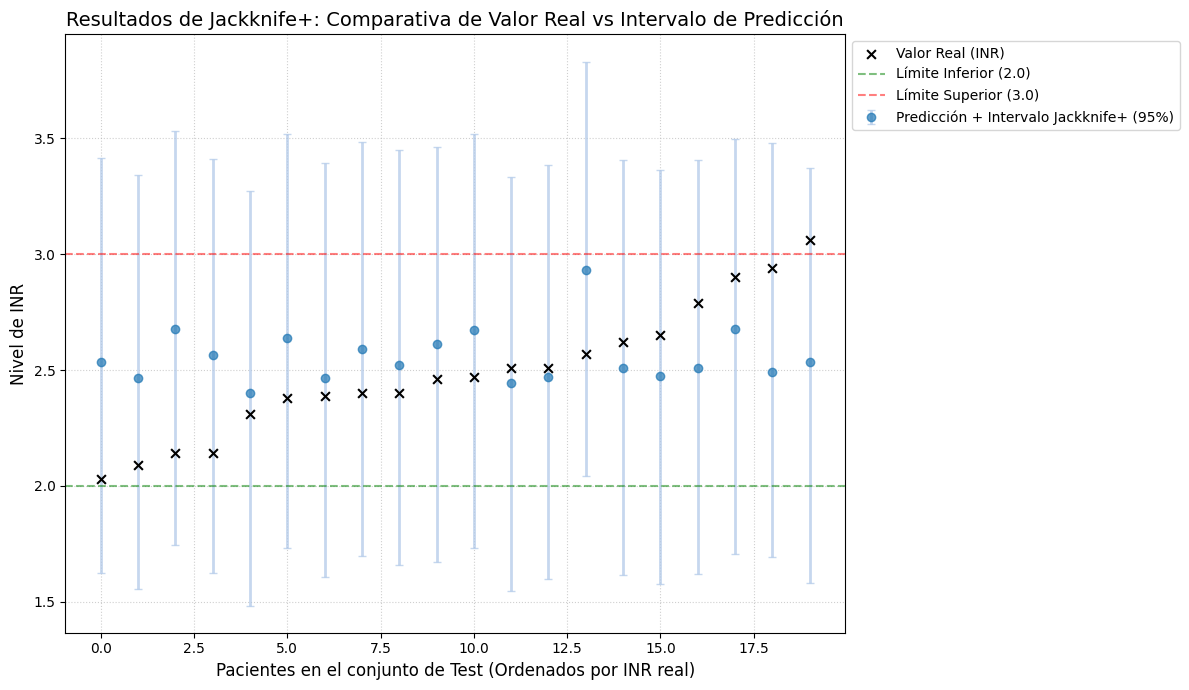

In [21]:

# 2. Configurar MAPIE para Jackknife+ (Cross-Validation)
# cv=5 o cv=10 es lo estándar. 
# cv=KFold(...) nos permite controlar la aleatoriedad.

kf = KFold(n_splits=5, shuffle=True, random_state=23)

mapie_cv = MapieRegressor(
    estimator=rf_model, 
    cv=kf, 
    method="plus", # "plus" implementa Jackknife+
    n_jobs=-1
)

# 3. Entrenar (Aquí MAPIE entrena el RF 5 veces internamente)
# Usamos el set de entrenamiento completo (df_train)
mapie_cv.fit(df_X_train, y_train)

# 4. Predecir sobre el test set
alpha = 0.05
y_pred_cv, y_pis_cv = mapie_cv.predict(X_test, alpha=alpha)

# Extraer límites
y_lower_cv = y_pis_cv[:, 0, 0]
y_upper_cv = y_pis_cv[:, 1, 0]
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Organizamos los resultados para el gráfico
# Usamos y_pred_cv, y_lower_cv y y_upper_cv que generaste con mapie_cv
df_res_cv = pd.DataFrame({
    'Real': y_test,
    'Predicho': y_pred_cv,
    'Inferior': y_lower_cv,
    'Superior': y_upper_cv
}).sort_values(by='Real').reset_index(drop=True)

# 2. Configuración del gráfico
plt.figure(figsize=(12, 7))

# Dibujar los intervalos de predicción (las barras de error)
plt.errorbar(df_res_cv.index, df_res_cv['Predicho'], 
             yerr=[df_res_cv['Predicho'] - df_res_cv['Inferior'], 
                   df_res_cv['Superior'] - df_res_cv['Predicho']],
             fmt='o', color='#1f77b4', ecolor='#aec7e8', elinewidth=2, capsize=3,
             label='Predicción + Intervalo Jackknife+ (95%)', alpha=0.7)

# Dibujar los valores reales (puntos negros)
plt.scatter(df_res_cv.index, df_res_cv['Real'], color='black', marker='x', s=40, 
            label='Valor Real (INR)', zorder=5)

# 3. Líneas de referencia clínica (Rango Terapéutico Estándar)
plt.axhline(y=2.0, color='green', linestyle='--', alpha=0.5, label='Límite Inferior (2.0)')
plt.axhline(y=3.0, color='red', linestyle='--', alpha=0.5, label='Límite Superior (3.0)')

# 4. Estética
plt.title('Resultados de Jackknife+: Comparativa de Valor Real vs Intervalo de Predicción', fontsize=14)
plt.xlabel('Pacientes en el conjunto de Test (Ordenados por INR real)', fontsize=12)
plt.ylabel('Nivel de INR', fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()


## Intervalo editado 80%

In [ ]:
# 2. Configurar MAPIE para Jackknife+ (Cross-Validation)
# cv=5 o cv=10 es lo estándar. 
# cv=KFold(...) nos permite controlar la aleatoriedad.
kf = KFold(n_splits=5, shuffle=True, random_state=23)

mapie_cv = MapieRegressor(
    estimator=rf_model, 
    cv=kf, 
    method="plus", # "plus" implementa Jackknife+
    n_jobs=-1
)

# 3. Entrenar (Aquí MAPIE entrena el RF 5 veces internamente)
# Usamos el set de entrenamiento completo (df_train)
mapie_cv.fit(X_proper_train, y_proper_train)

# 4. Predecir sobre el test set
alpha = 0.20
y_pred_cv, y_pis_cv = mapie_cv.predict(X_test, alpha=alpha)

# Extraer límites
y_lower_cv = y_pis_cv[:, 0, 0]
y_upper_cv = y_pis_cv[:, 1, 0]
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 1. Organizamos los resultados para el gráfico
# Usamos y_pred_cv, y_lower_cv y y_upper_cv que generaste con mapie_cv
df_res_cv = pd.DataFrame({
    'Real': y_test,
    'Predicho': y_pred_cv,
    'Inferior': y_lower_cv,
    'Superior': y_upper_cv
}).sort_values(by='Real').reset_index(drop=True)

# 2. Configuración del gráfico
plt.figure(figsize=(12, 7))

# Dibujar los intervalos de predicción (las barras de error)
plt.errorbar(df_res_cv.index, df_res_cv['Predicho'], 
             yerr=[df_res_cv['Predicho'] - df_res_cv['Inferior'], 
                   df_res_cv['Superior'] - df_res_cv['Predicho']],
             fmt='o', color='#1f77b4', ecolor='#aec7e8', elinewidth=2, capsize=3,
             label='Predicción + Intervalo Jackknife+ (95%)', alpha=0.7)

# Dibujar los valores reales (puntos negros)
plt.scatter(df_res_cv.index, df_res_cv['Real'], color='black', marker='x', s=40, 
            label='Valor Real (INR)', zorder=5)

# 3. Líneas de referencia clínica (Rango Terapéutico Estándar)
plt.axhline(y=2.0, color='green', linestyle='--', alpha=0.5, label='Límite Inferior (2.0)')
plt.axhline(y=3.0, color='red', linestyle='--', alpha=0.5, label='Límite Superior (3.0)')

# 4. Estética
plt.title('Resultados de Jackknife+: Comparativa de Valor Real vs Intervalo de Predicción', fontsize=14)
plt.xlabel('Pacientes en el conjunto de Test (Ordenados por INR real)', fontsize=12)
plt.ylabel('Nivel de INR', fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()

## Método de Cálculo de Residuos
### Residuos Homocedásticos

In [22]:
# 1. Configuración del Regresor MAPIE con Residuos Homocedásticos
# El parámetro method="base" asegura que los intervalos sean de ancho constante
mapie_homo = MapieRegressor(
    estimator=rf_model, # Tu modelo Random Forest
    method="base",      # Método para residuos homocedásticos
    cv="prefit",        # Si ya lo entrenaste (Split), o usa un entero/KFold (Jackknife+)
    n_jobs=-1
)
# 2. Ajuste del modelo
# Si usas Split: mapie_homo.fit(X_cal, y_cal)
# Si usas Jackknife+: mapie_homo.fit(X_train_full, y_train_full)
mapie_homo.fit(X_cal, y_cal) 

# 3. Generación de predicciones e intervalos (alpha=0.05 -> 95% confianza)
alpha = 0.05
y_pred, y_pis = mapie_homo.predict(X_test, alpha=alpha)

# 4. Extracción de los límites del intervalo
# La estructura de y_pis es [n_muestras, [lim_inf, lim_sup], n_alphas]
y_lower = y_pis[:, 0, 0]
y_upper = y_pis[:, 1, 0]

# 5. Verificación de la Homocedasticidad (Ancho constante)
widths = y_upper - y_lower
print(f"Ancho del primer intervalo: {widths[0]:.4f}")
print(f"Ancho del último intervalo: {widths[-1]:.4f}")
print(f"¿Son todos los intervalos iguales?: {np.allclose(widths, widths[0])}")

Ancho del primer intervalo: 1.4613
Ancho del último intervalo: 1.4613
¿Son todos los intervalos iguales?: True


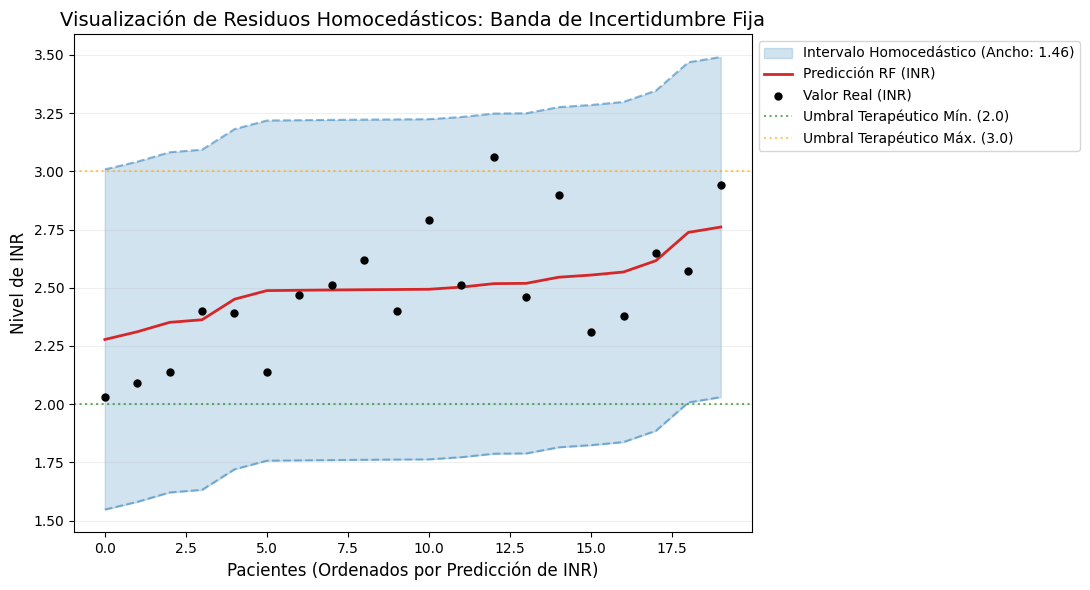

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. Preparar los datos (ordenados por la predicción para ver la banda limpia)
df_homo = pd.DataFrame({
    'Real': y_test,
    'Predicho': y_pred,
    'Lower': y_lower,
    'Upper': y_upper
}).sort_values(by='Predicho').reset_index(drop=True)

# 2. Crear la visualización
plt.figure(figsize=(11, 6))

# Dibujar el área de incertidumbre (la banda constante)
plt.fill_between(df_homo.index, df_homo['Lower'], df_homo['Upper'], 
                 color='tab:blue', alpha=0.2, label=f'Intervalo Homocedástico (Ancho: {df_homo["Upper"][0]-df_homo["Lower"][0]:.2f})')

# Dibujar los límites superior e inferior de la banda
plt.plot(df_homo.index, df_homo['Lower'], color='tab:blue', linestyle='--', alpha=0.5)
plt.plot(df_homo.index, df_homo['Upper'], color='tab:blue', linestyle='--', alpha=0.5)

# Dibujar la predicción puntual
plt.plot(df_homo.index, df_homo['Predicho'], color='tab:red', label='Predicción RF (INR)', linewidth=2)

# Dibujar los valores reales
plt.scatter(df_homo.index, df_homo['Real'], color='black', s=25, label='Valor Real (INR)', zorder=3)

# 3. Líneas de referencia clínica
plt.axhline(y=2.0, color='green', linestyle=':', alpha=0.6, label='Umbral Terapéutico Mín. (2.0)')
plt.axhline(y=3.0, color='orange', linestyle=':', alpha=0.6, label='Umbral Terapéutico Máx. (3.0)')

# 4. Estética del gráfico
plt.title('Visualización de Residuos Homocedásticos: Banda de Incertidumbre Fija', fontsize=14)
plt.xlabel('Pacientes (Ordenados por Predicción de INR)', fontsize=12)
plt.ylabel('Nivel de INR', fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(axis='y', alpha=0.2)

plt.tight_layout()
plt.show()

### Residuos Heterocedásticos (CQR - Conformal Quantile Regression)

In [25]:
from sklearn.ensemble import GradientBoostingRegressor

# 1. Definimos el estimador base (sin entrenar)
estimator = GradientBoostingRegressor(
    loss="quantile", 
    n_estimators=100, # Reducimos un poco para velocidad en el CV
    random_state=23
)

# 2. Cambiamos "prefit" por 5 para usar Validación Cruzada (Jackknife-like CQR)
mapie_cqr = MapieQuantileRegressor(
    estimator=estimator,
    method="quantile",
    cv="split",            # MAPIE se encarga de entrenar y calibrar 
)

# 3. Entrenamos con el set de entrenamiento completo (el que une proper_train + cal)
# Esto es más eficiente para datasets de tu tamaño (~130 pacientes)
mapie_cqr.fit(X_proper_train, y_proper_train)

# 4. Predicción e intervalos
y_pred_cqr, y_pis_cqr = mapie_cqr.predict(X_test, alpha=0.05)

# 5. Extracción de límites
y_lower_cqr = y_pis_cqr[:, 0, 0]
y_upper_cqr = y_pis_cqr[:, 1, 0]

# 6. Verificación de Heterocedasticidad (Ancho variable)
widths_cqr = y_upper_cqr - y_lower_cqr
print(f"Ancho mínimo detectado: {widths_cqr.min():.4f}")
print(f"Ancho máximo detectado: {widths_cqr.max():.4f}")
print(f"¿Son todos los intervalos iguales?: {np.allclose(widths_cqr, widths_cqr[0])}")

Ancho mínimo detectado: 1.0866
Ancho máximo detectado: 1.6558
¿Son todos los intervalos iguales?: False


c:\Users\VALER\AppData\Local\Programs\Python\Python39\lib\site-packages\mapie\utils.py:703: UserWarning: WARNING: Alpha should not be specified in the prediction method
with conformalized quantile regression.
  warnings.warn(
c:\Users\VALER\AppData\Local\Programs\Python\Python39\lib\site-packages\mapie\utils.py:621: UserWarning: WARNING: The predictions are ill-sorted.
  warnings.warn(


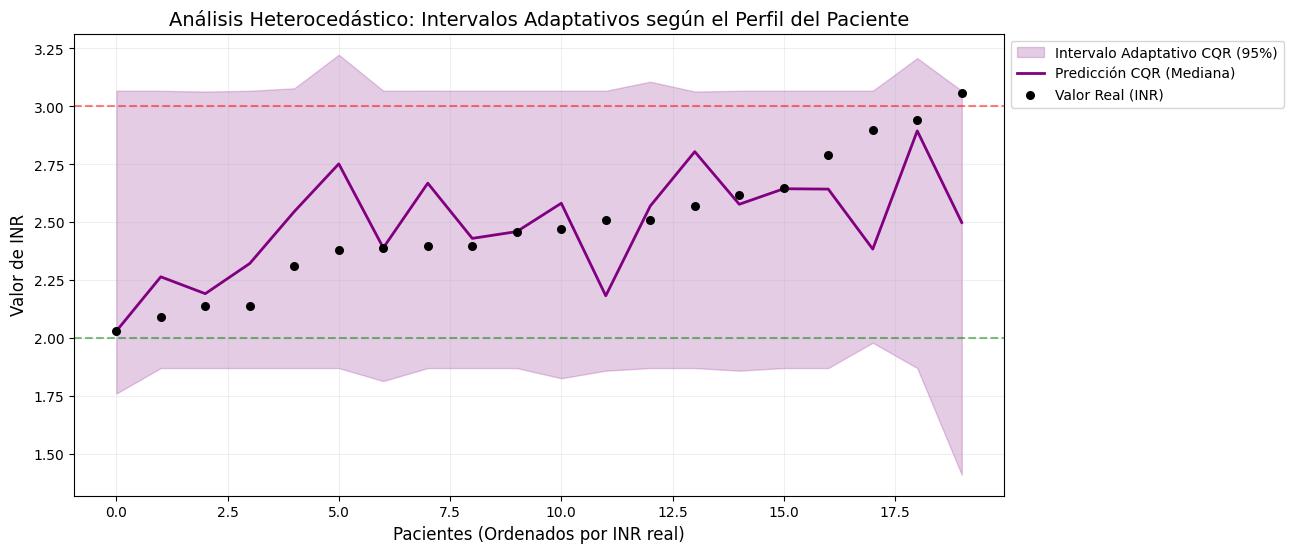

In [26]:
# Preparar datos ordenados por el valor real
df_cqr = pd.DataFrame({
    'Real': y_test,
    'Predicho': y_pred_cqr,
    'Lower': y_lower_cqr,
    'Upper': y_upper_cqr
}).sort_values(by='Real').reset_index(drop=True)

plt.figure(figsize=(12, 6))

# Área sombreada variable (Heterocedástica)
plt.fill_between(df_cqr.index, df_cqr['Lower'], df_cqr['Upper'], 
                 color='purple', alpha=0.2, label='Intervalo Adaptativo CQR (95%)')

plt.plot(df_cqr.index, df_cqr['Predicho'], color='purple', label='Predicción CQR (Mediana)', linewidth=2)
plt.scatter(df_cqr.index, df_cqr['Real'], color='black', s=30, label='Valor Real (INR)', zorder=3)

plt.axhline(y=2.0, color='green', linestyle='--', alpha=0.5)
plt.axhline(y=3.0, color='red', linestyle='--', alpha=0.5)

plt.title('Análisis Heterocedástico: Intervalos Adaptativos según el Perfil del Paciente', fontsize=14)
plt.xlabel('Pacientes (Ordenados por INR real)', fontsize=12)
plt.ylabel('Valor de INR', fontsize=12)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(alpha=0.2)
plt.show()

## Transferibilidad y detección de sesgos
### Detección de Sesgos en el Dataset Actual

--- DISTRIBUCIÓN DE SESGO DE SELECCIÓN ---
Categoria_INR
Rango Objetivo (Estable)                62.869458
Supraterapéutico (Riesgo Hemorragia)    18.903941
Subterapéutico (Riesgo Trombosis)       18.226601
Name: proportion, dtype: float64


C:\Users\VALER\AppData\Local\Temp\ipykernel_11404\185790242.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Categoria_INR', data=df, palette='viridis', order=[


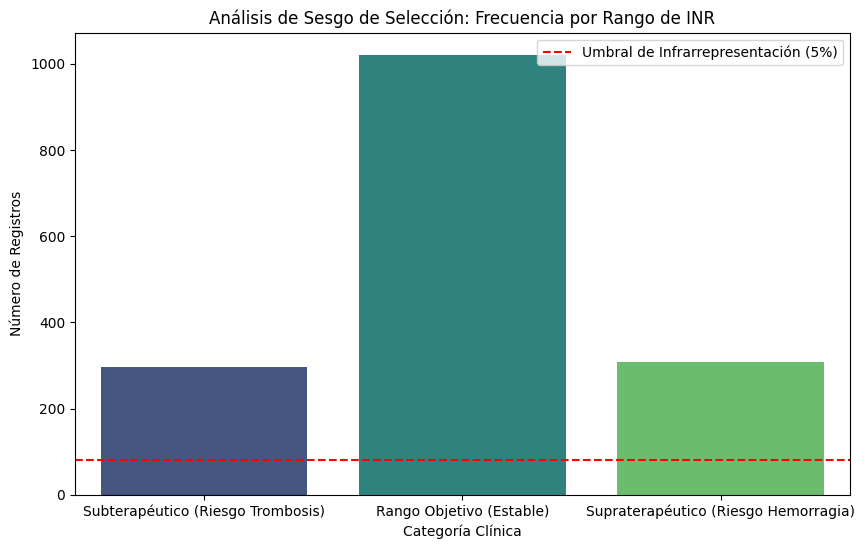

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df_inicial = pd.read_excel("data/Estudi_Anticoagulants.xlsx", sheet_name="PARAM COAG")


df = (
    df_inicial.groupby(["CODI_PACIENT","DATA"])
      .mean(numeric_only=True)
      .reset_index()
)

# 1. Clasificación por Rangos Clínicos
def clasificar_inr(inr):
    if inr < 2.0:
        return 'Subterapéutico (Riesgo Trombosis)'
    elif 2.0 <= inr <= 3.0:
        return 'Rango Objetivo (Estable)'
    else:
        return 'Supraterapéutico (Riesgo Hemorragia)'

df['Categoria_INR'] = df['VALOR'].apply(clasificar_inr)

# 2. Cálculo de frecuencias y porcentajes
conteo_sesgo = df['Categoria_INR'].value_counts(normalize=True) * 100

print("--- DISTRIBUCIÓN DE SESGO DE SELECCIÓN ---")
print(conteo_sesgo)

# 3. Visualización del desequilibrio
plt.figure(figsize=(10, 6))
sns.countplot(x='Categoria_INR', data=df, palette='viridis', order=[
    'Subterapéutico (Riesgo Trombosis)', 
    'Rango Objetivo (Estable)', 
    'Supraterapéutico (Riesgo Hemorragia)'
])
plt.title('Análisis de Sesgo de Selección: Frecuencia por Rango de INR')
plt.ylabel('Número de Registros')
plt.xlabel('Categoría Clínica')
plt.axhline(y=len(df)*0.05, color='red', linestyle='--', label='Umbral de Infrarrepresentación (5%)')
plt.legend()
plt.show()

--- DISTRIBUCIÓN DE SESGO DE ESTACIONALIDAD ---
Estacion
Verano       27.032020
Primavera    26.539409
Otoño        26.354680
Invierno     20.073892
Name: proportion, dtype: float64


C:\Users\VALER\AppData\Local\Temp\ipykernel_11404\1114747566.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Estacion', data=df, palette='viridis', order=[


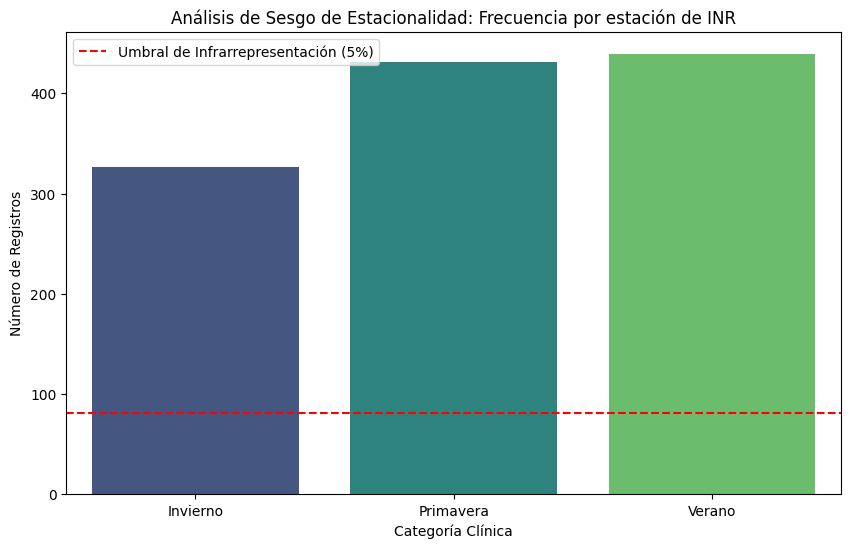

In [28]:
# 1. Crear la variable estación
def obtener_estacion(fecha):
    mes = fecha.month
    if mes in [12, 1, 2]: return 'Invierno'
    elif mes in [3, 4, 5]: return 'Primavera'
    elif mes in [6, 7, 8]: return 'Verano'
    else: return 'Otoño'

df['DATA'] = pd.to_datetime(df['DATA'], format='%m/%Y')
df['Estacion'] = df['DATA'].apply(obtener_estacion)



# 2. Cálculo de frecuencias y porcentajes
conteo_sesgo = df['Estacion'].value_counts(normalize=True) * 100

print("--- DISTRIBUCIÓN DE SESGO DE ESTACIONALIDAD ---")
print(conteo_sesgo)

# 3. Visualización del desequilibrio
plt.figure(figsize=(10, 6))
sns.countplot(x='Estacion', data=df, palette='viridis', order=[
    'Invierno', 
    'Primavera', 
    'Verano'
])
plt.title('Análisis de Sesgo de Estacionalidad: Frecuencia por estación de INR')
plt.ylabel('Número de Registros')
plt.xlabel('Categoría Clínica')
plt.axhline(y=len(df)*0.05, color='red', linestyle='--', label='Umbral de Infrarrepresentación (5%)')
plt.legend()
plt.show()

In [29]:
df_bias = pd.DataFrame(X_test, columns=feature_names)

# 2. Convertir predicciones e intervalos a arrays 1D
actual = np.asarray(y_test).flatten()
predicho = np.asarray(y_pred_cqr).flatten()  # Usar y_pred_cv si prefieres CV
limite_inferior = np.asarray(y_lower_cqr).flatten()
limite_superior = np.asarray(y_upper_cqr).flatten()


# 3. Añadir resultados al DataFrame
df_bias['Real'] = actual
df_bias['Prediccion'] = predicho
df_bias['Error_Absoluto'] = np.abs(actual - predicho)
df_bias['Ancho_Intervalo'] = limite_superior - limite_inferior
df_bias['Limite_Inferior'] = limite_inferior
df_bias['Limite_Superior'] = limite_superior

# 4. Verificar si el valor real está dentro del intervalo
df_bias['Dentro_Intervalo'] = (
    (df_bias['Real'] >= df_bias['Limite_Inferior']) & 
    (df_bias['Real'] <= df_bias['Limite_Superior'])
)


In [30]:
paciente_1 = {
  "CALCI": 8.6,
  "HEMOGLOBINA": 10.9,
  "VCM": 95,
  "HEMATOCRIT": 33,
  "PLAQUETES": 165,
  "IMC": 23.4,
  "HB_GLICOSILADA_A1C": 6.1,
  "PES": 54,
  "CRIBRATGE_ALIMENTACIO": 6.0,
  "MAGNESI": 1.5,
  "CLORUR": 97,
  "CBPAAT": 138,
  "VALORACIO_AUDIT_C": 0,
  "NT_PROBNP": 8200,
  "CREATINA_KINASA_CK": 98,
  "FREQ_CARDIACA": 96,
  "PCR": 6.2,
  "HEMATIES": 3.5,
  "DIAGNOSTIC_ASSOCIAT=FA_NE": 0,
  "DIAGNOSTIC_ASSOCIAT=EP_Other_No_CorPulm": 0,
  "DIAGNOSTIC_ASSOCIAT=FA_Cron": 1,
  "DIAGNOSTIC_ASSOCIAT=Flebitis_Profunda": 0
}
# 1. Definimos el paciente (puedes cambiarlo por el de Urgencias si prefieres)
paciente_eval = pd.DataFrame([paciente_1]) 

# 2. Diccionario de modelos para iterar
modelos_incertidumbre = {
    "Homocedástico (Base)": mapie_homo,
    "Heterocedástico (CQR)": mapie_cqr,
    "Jackknife+ (CV)": mapie_cv
}

resultados = []

print(f"--- ANÁLISIS MULTIMÉTODO DE INCERTIDUMBRE (Alpha=0.20) ---")

for nombre, modelo in modelos_incertidumbre.items():
    # Predicción (usamos alpha=0.20 para que sea coherente con tu gráfico del 80%)
    y_pred, y_pis = modelo.predict(paciente_eval, alpha=0.20)
    
    inf = y_pis[0, 0, 0]
    sup = y_pis[0, 1, 0]
    ancho = sup - inf
    
    resultados.append({
        "Método": nombre,
        "Predicción": round(y_pred[0], 2),
        "Límite Inf": round(inf, 2),
        "Límite Sup": round(sup, 2),
        "Ancho": round(ancho, 4)
    })

# 3. Mostrar tabla comparativa
df_comparativo = pd.DataFrame(resultados)
print(df_comparativo.to_string(index=False))

--- ANÁLISIS MULTIMÉTODO DE INCERTIDUMBRE (Alpha=0.20) ---


c:\Users\VALER\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
c:\Users\VALER\AppData\Local\Programs\Python\Python39\lib\site-packages\mapie\utils.py:703: UserWarning: WARNING: Alpha should not be specified in the prediction method
with conformalized quantile regression.
  warnings.warn(
c:\Users\VALER\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
c:\Users\VALER\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(
c:\Users\VALER\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning:

               Método  Predicción  Límite Inf  Límite Sup  Ancho
 Homocedástico (Base)        2.70        2.27        3.13 0.8598
Heterocedástico (CQR)        2.69        1.97        3.07 1.1001
      Jackknife+ (CV)        2.70        2.21        3.19 0.9757
